In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!apt-get update -qq
!apt-get install -qq fonts-nanum -y

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 126111 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [2]:
!ls /usr/share/fonts/truetype/nanum/

NanumBarunGothicBold.ttf   NanumGothicCoding.ttf  NanumSquareB.ttf
NanumBarunGothic.ttf	   NanumGothic.ttf	  NanumSquareRoundB.ttf
NanumGothicBold.ttf	   NanumMyeongjoBold.ttf  NanumSquareRoundR.ttf
NanumGothicCodingBold.ttf  NanumMyeongjo.ttf	  NanumSquareR.ttf


In [3]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from glob import glob

# 1) 나눔 폰트가 설치된 경로
nanum_dir = '/usr/share/fonts/truetype/nanum/'

# 2) ttf 파일을 한 번에 Matplotlib에 등록
for font_path in glob(nanum_dir + '*.ttf'):
    fm.fontManager.addfont(font_path)

# 3) 추가된 나눔폰트가 Matplotlib에 제대로 등록되었는지 확인
nanum_fonts = sorted({f.name for f in fm.fontManager.ttflist if 'Nanum' in f.name})
print("▶ Matplotlib이 인식하는 'Nanum' 계열 폰트들:")
for name in nanum_fonts:
    print("-", name)

▶ Matplotlib이 인식하는 'Nanum' 계열 폰트들:
- NanumBarunGothic
- NanumGothic
- NanumGothicCoding
- NanumMyeongjo
- NanumSquare
- NanumSquareRound


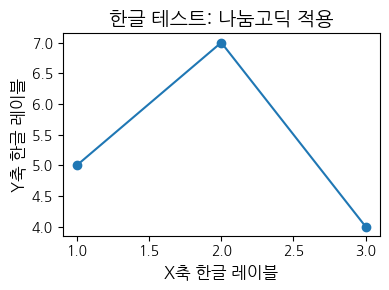

In [4]:
import matplotlib.pyplot as plt

# (1) 3번 단계에서 출력된 정확한 이름을 복사해 넣으세요.
plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False)  # 음수 기호가 깨지지 않도록 설정

# (2) 테스트 플롯: 한글이 제대로 나오는지 확인
plt.figure(figsize=(4,3))
plt.title("한글 테스트: 나눔고딕 적용", fontsize=14)
plt.plot([1,2,3], [5,7,4], marker='o')
plt.xlabel("X축 한글 레이블", fontsize=12)
plt.ylabel("Y축 한글 레이블", fontsize=12)
plt.tight_layout()
plt.show()

In [7]:
import pandas as pd
import numpy as np
import ast

# 1) CSV 파일 읽기
df = pd.read_csv('/content/drive/MyDrive/final_data_rebounds.csv')

# 2) '상영일수' 칼럼이 문자열이 아닌 정수/실수형이라면 바로 사용 가능
df['상영일수'] = pd.to_numeric(df['상영일수'], errors='coerce')
df['개봉일'] = pd.to_datetime(df['개봉일'], format='%Y-%m-%d', errors='coerce')

# 2-1) 새로 추가된 '3일뒤_재반등횟수', '7일뒤_재반등횟수', '10일뒤_재반등횟수'도 숫자형으로 변환
for col in ['3일뒤_재반등횟수', '7일뒤_재반등횟수', '10일뒤_재반등횟수']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# 4) 리스트 형태 문자열 칼럼(예: '조회일', '관객수', '매출액')은 ast.literal_eval로 파싱하되,
#    상영일수를 유추하는 방향이 아니라, 이미 계산된 통계량만 사용해야 함
def safe_literal_eval(x):
    try:
        return ast.literal_eval(x)
    except:
        return []

# 상영일수와 상관관계만 참고
df['조회일 리스트'] = df['조회일'].astype(str).apply(safe_literal_eval)
df['관객수 리스트'] = df['관객수'].astype(str).apply(safe_literal_eval)
df['매출액 리스트'] = df['매출액'].astype(str).apply(safe_literal_eval)

# 5) 결측치 처리: 모델링에 필요한 피처와 타깃이 결측인 행 제거
required_cols = ['상영일수']
df_model = df.dropna(subset=required_cols).copy()

# 7) 최종 모델용 피처 리스트 정의
feature_cols = []

# (1) 이미 가공된 통계 피처들
stat_cols = [
    '관객수_mean', '관객수_std', '관객수_min', '관객수_max',
    '관객수_first', '관객수_last', '관객수_sum',
    '관객수_volatility', '관객수_slope', '관객수_peak_offset', '관객수_peak_value',
    '관객수_early_peak', '관객수_sum_after',
    '스크린수_mean', '스크린수_std', '스크린수_min', '스크린수_max',
    '스크린수_first', '스크린수_last', '스크린수_sum',
    '스크린수_volatility', '스크린수_slope', '스크린수_peak_offset', '스크린수_peak_value',
    '스크린수_early_peak', '스크린수_sum_after',
    '상영횟수_mean', '상영횟수_std', '상영횟수_min', '상영횟수_max',
    '상영횟수_first', '상영횟수_last', '상영횟수_sum',
    '상영횟수_volatility', '상영횟수_slope', '상영횟수_peak_offset', '상영횟수_peak_value',
    '상영횟수_early_peak', '상영횟수_sum_after'
]
feature_cols += [c for c in stat_cols if c in df_model.columns]

# (2) 원-핫 인코딩된 장르·국적 칼럼
genre_cols = [c for c in df_model.columns if c.startswith('장르_')]
country_cols = [c for c in df_model.columns if c.startswith('국적_')]
feature_cols += genre_cols + country_cols

# (5) 기타 점수형 피처
score_cols = [
    '배우_점수', '배우_영화수_점수', '배우_매출액_점수',
    '감독_점수', '감독_영화수_점수', '감독_매출액_점수',
    '배급사_점수', '배급사_영화수_점수', '배급사_매출액_점수',
    '반감기', '재반등횟수',
    '흥행안정성지수_3일', '흥행안정성지수_10일',
    '3일뒤_재반등횟수', '7일뒤_재반등횟수', '10일뒤_재반등횟수'
]
feature_cols += [c for c in score_cols if c in df_model.columns]

for col in feature_cols:
    # to_numeric → 변환 실패하면 NaN
    df_model[col] = pd.to_numeric(df_model[col], errors='coerce')

    # 결측(NaN)이 있으면 평균값으로 채우기
    # (필요에 따라 중앙값이나 0, 혹은 drop 옵션을 선택하셔도 됩니다)
    mean_val = df_model[col].mean()
    df_model[col].fillna(mean_val, inplace=True)

# 최종: feature_cols에 포함되지 않은 칼럼은 모델 입력에서 제외
X = df_model[feature_cols]
y = df_model['상영일수']
print("▶ 최종 feature 개수:", len(feature_cols))

▶ 최종 feature 개수: 101


<ipython-input-7-bdce832c055b>:77: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_model[col].fillna(mean_val, inplace=True)



=== 실험: '3일뒤_재반등횟수' 만 사용 (피처 수: 98) ===
 threshold=0.80 | dropped=27 | Val RMSE=12.082 | Test RMSE=10.352 | R²=0.766
 threshold=0.85 | dropped=26 | Val RMSE=12.552 | Test RMSE=9.990 | R²=0.782
 threshold=0.90 | dropped=22 | Val RMSE=4.394 | Test RMSE=3.561 | R²=0.972
 threshold=0.95 | dropped=15 | Val RMSE=5.050 | Test RMSE=3.489 | R²=0.973
 threshold=1.00 | dropped= 0 | Val RMSE=4.222 | Test RMSE=3.379 | R²=0.975

=== 실험: '7일뒤_재반등횟수' 만 사용 (피처 수: 98) ===
 threshold=0.80 | dropped=27 | Val RMSE=12.018 | Test RMSE=10.528 | R²=0.758
 threshold=0.85 | dropped=26 | Val RMSE=12.164 | Test RMSE=10.169 | R²=0.774
 threshold=0.90 | dropped=22 | Val RMSE=4.379 | Test RMSE=3.547 | R²=0.973
 threshold=0.95 | dropped=15 | Val RMSE=5.153 | Test RMSE=3.448 | R²=0.974
 threshold=1.00 | dropped= 0 | Val RMSE=4.275 | Test RMSE=3.412 | R²=0.975

=== 실험: '10일뒤_재반등횟수' 만 사용 (피처 수: 98) ===
 threshold=0.80 | dropped=27 | Val RMSE=11.994 | Test RMSE=10.480 | R²=0.760
 threshold=0.85 | dropped=26 | Val RMSE=12

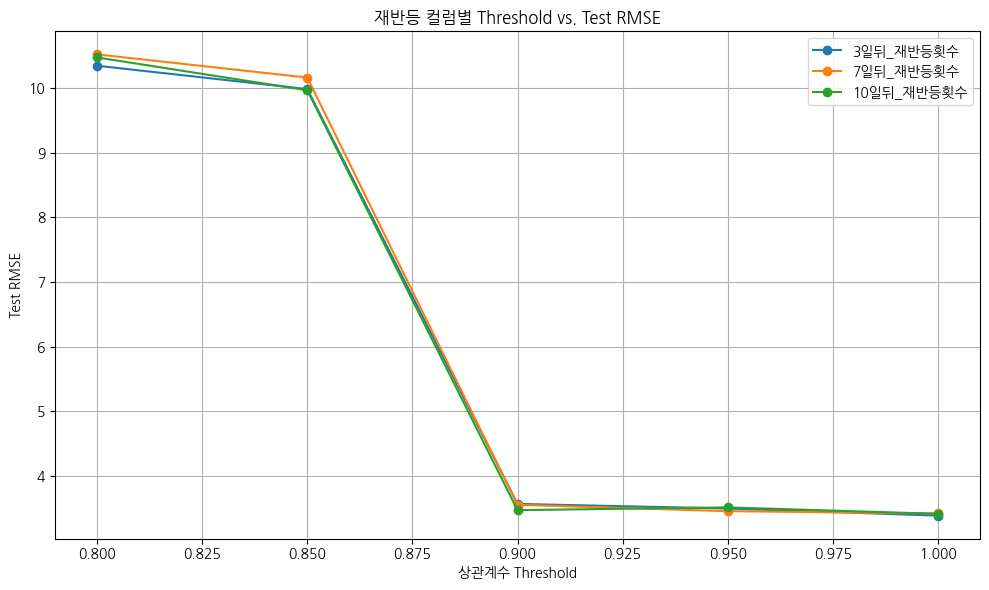

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 실험 대상 재반등 컬럼
rebound_cols = ['3일뒤_재반등횟수', '7일뒤_재반등횟수', '10일뒤_재반등횟수']

# (1) base_features: 재반등 컬럼 3개 + 일반 '재반등횟수' 컬럼을 모두 제외
exclude_cols = rebound_cols + ['재반등횟수']
base_features = [c for c in feature_cols if c not in exclude_cols]

# (2) threshold 리스트
thresholds = [0.8, 0.85, 0.9, 0.95, 1.0]

all_results = []

for rebound in rebound_cols:
    # 실험용 피처: base + 단일 rebound 컬럼
    curr_features = base_features + [rebound]
    X = df_model[curr_features]
    y = df_model['상영일수']

    # Train/Val/Test 분할 (고정)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42
    )

    print(f"\n=== 실험: '{rebound}' 만 사용 (피처 수: {len(curr_features)}) ===")

    for thresh in thresholds:
        # 상관행렬 생성
        X_tr_val = pd.concat([X_train, X_val], axis=0)
        corr = X_tr_val.corr().abs()
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

        # drop 후보
        to_drop = [c for c in upper.columns if any(upper[c] > thresh)]

        # 데이터에서 피처 제거
        X_tr_sub = X_train.drop(columns=to_drop)
        X_val_sub = X_val.drop(columns=to_drop)
        X_te_sub = X_test.drop(columns=to_drop)

        # 모델 학습
        model = xgb.XGBRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            eval_metric='rmse'
        )
        model.fit(X_tr_sub, y_train, eval_set=[(X_val_sub, y_val)], verbose=False)

        # 평가
        yv = model.predict(X_val_sub)
        yt = model.predict(X_te_sub)
        rmse_val = np.sqrt(mean_squared_error(y_val, yv))
        rmse_test = np.sqrt(mean_squared_error(y_test, yt))
        r2 = r2_score(y_test, yt)

        print(f" threshold={thresh:.2f} | dropped={len(to_drop):2d} | "
              f"Val RMSE={rmse_val:.3f} | Test RMSE={rmse_test:.3f} | R²={r2:.3f}")

        all_results.append({
            'rebound': rebound,
            'threshold': thresh,
            'n_dropped': len(to_drop),
            'val_rmse': rmse_val,
            'test_rmse': rmse_test,
            'test_r2': r2
        })

# 결과 정리 및 시각화
df_all = pd.DataFrame(all_results)
print("\n=== 전체 실험 결과 ===")
print(df_all)

plt.figure(figsize=(10, 6))
for rebound in rebound_cols:
    sub = df_all[df_all['rebound']==rebound]
    plt.plot(sub['threshold'], sub['test_rmse'], marker='o', label=rebound)
plt.xlabel("상관계수 Threshold")
plt.ylabel("Test RMSE")
plt.title("재반등 컬럼별 Threshold vs. Test RMSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

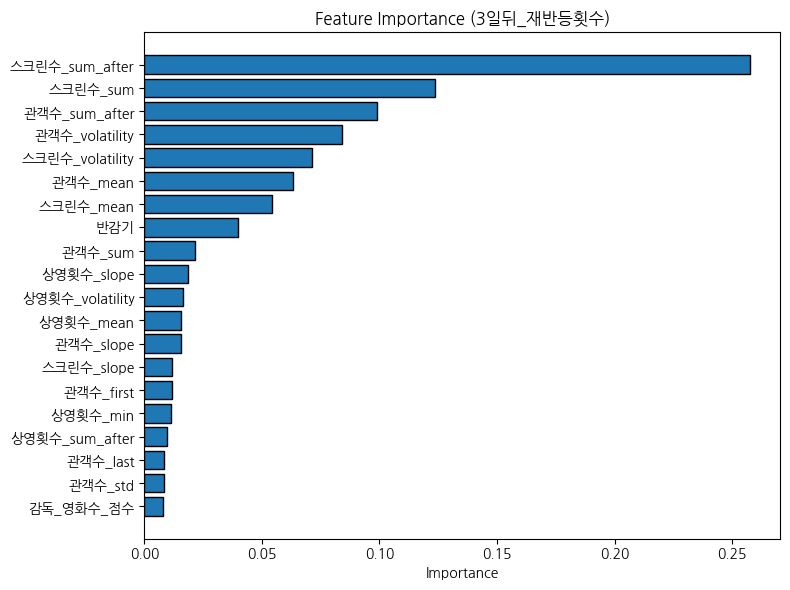

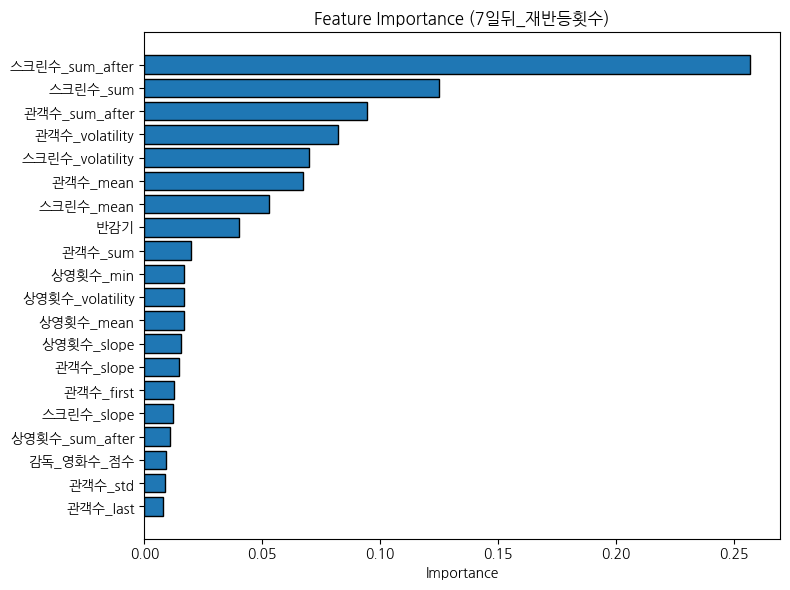

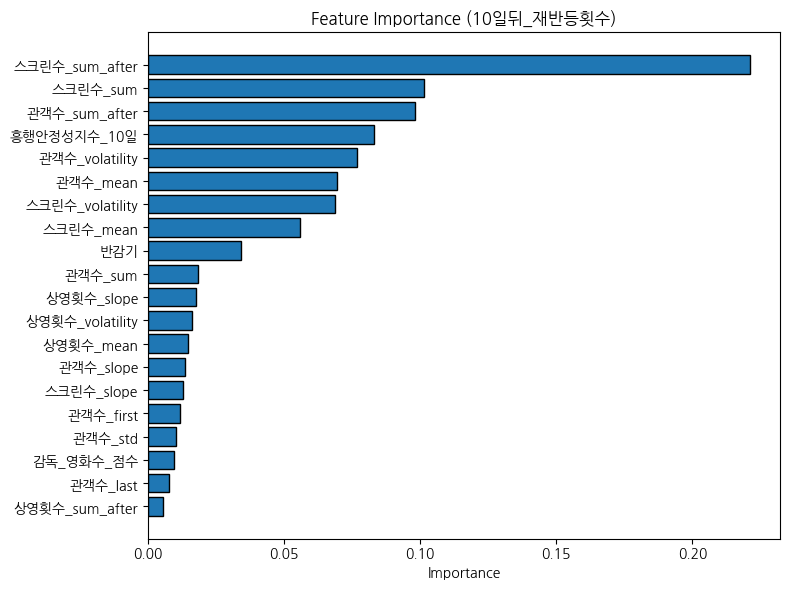

In [9]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# (1) 공통 하이퍼파라미터 정의
xgb_params = dict(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='rmse'
)

# (2) 베이스 피처 목록 (재반등횟수 컬럼을 제외한 모든 feature_cols)
base_features = [c for c in feature_cols if c not in ['3일뒤_재반등횟수','7일뒤_재반등횟수', '10일뒤_재반등횟수', '재반등횟수', '흥행안정성지수_3일', '흥행안정성지수_10일']]

# (3) 그래프 출력 함수
def plot_feature_importance(model, feats, top_n=20, title="Feature Importance"):
    imp = model.feature_importances_
    idx = np.argsort(imp)[::-1][:top_n]
    names = [feats[i] for i in idx]
    scores = imp[idx]

    plt.rc('font', family='NanumGothic')
    plt.rc('axes', unicode_minus=False)
    plt.figure(figsize=(8,6))
    plt.title(title)
    plt.barh(names[::-1], scores[::-1], edgecolor='k')
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

# (4) '3일뒤_재반등횟수' 만 사용하는 모델 학습 & 중요도
feats_3 = base_features + ['3일뒤_재반등횟수', '흥행안정성지수_3일']
X3 = df_model[feats_3]
y  = df_model['상영일수']
X3_train, X3_temp, y3_train, y3_temp = train_test_split(X3, y, test_size=0.3, random_state=42)
X3_val,   X3_test, y3_val,   y3_test = train_test_split(X3_temp, y3_temp, test_size=0.5, random_state=42)

model_3 = xgb.XGBRegressor(**xgb_params)
model_3.fit(X3_train, y3_train, eval_set=[(X3_val, y3_val)], verbose=False)
plot_feature_importance(model_3, feats_3, top_n=20, title="Feature Importance (3일뒤_재반등횟수)")

# (5) '7일뒤_재반등횟수' 만 사용하는 모델 학습 & 중요도
feats_7 = base_features + ['7일뒤_재반등횟수', '흥행안정성지수_3일']
X7 = df_model[feats_7]
X7_train, X7_temp, y7_train, y7_temp = train_test_split(X7, y, test_size=0.3, random_state=42)
X7_val,   X7_test, y7_val,   y7_test = train_test_split(X7_temp, y7_temp, test_size=0.5, random_state=42)

model_7 = xgb.XGBRegressor(**xgb_params)
model_7.fit(X7_train, y7_train, eval_set=[(X7_val, y7_val)], verbose=False)
plot_feature_importance(model_7, feats_7, top_n=20, title="Feature Importance (7일뒤_재반등횟수)")

# (5) '10일뒤_재반등횟수' 만 사용하는 모델 학습 & 중요도
feats_10 = base_features + ['10일뒤_재반등횟수', '흥행안정성지수_10일']
X10 = df_model[feats_10]
X10_train, X10_temp, y10_train, y10_temp = train_test_split(X10, y, test_size=0.3, random_state=42)
X10_val,   X10_test, y10_val,   y10_test = train_test_split(X10_temp, y10_temp, test_size=0.5, random_state=42)

model_10 = xgb.XGBRegressor(**xgb_params)
model_10.fit(X10_train, y10_train, eval_set=[(X10_val, y10_val)], verbose=False)
plot_feature_importance(model_10, feats_10, top_n=20, title="Feature Importance (10일뒤_재반등횟수)")

▶ 데이터 분할 완료 → Train: (4278, 101), Val: (917, 101), Test: (917, 101)

▶ Threshold = 0.80 기준으로 삭제할 피처 개수: 29
  ▶ After drop(29 features): Val RMSE = 5.873, Test RMSE = 5.987, Test R² = 0.922

▶ Threshold = 0.85 기준으로 삭제할 피처 개수: 27
  ▶ After drop(27 features): Val RMSE = 5.710, Test RMSE = 6.112, Test R² = 0.918

▶ Threshold = 0.90 기준으로 삭제할 피처 개수: 23
  ▶ After drop(23 features): Val RMSE = 3.884, Test RMSE = 3.968, Test R² = 0.966

▶ Threshold = 0.95 기준으로 삭제할 피처 개수: 15
  ▶ After drop(15 features): Val RMSE = 3.807, Test RMSE = 3.908, Test R² = 0.967

▶ Threshold = 1.00 기준으로 삭제할 피처 개수: 0
  ▶ After drop(0 features): Val RMSE = 3.614, Test RMSE = 4.080, Test R² = 0.964

=== Threshold별 모델 성능 비교 ===
   threshold  n_dropped  val_rmse  test_rmse   test_r2
0       0.80         29  5.873499   5.987072  0.921639
1       0.85         27  5.709607   6.111542  0.918347
2       0.90         23  3.883929   3.968079  0.965578
3       0.95         15  3.806534   3.907974  0.966613
4       1.00          0  

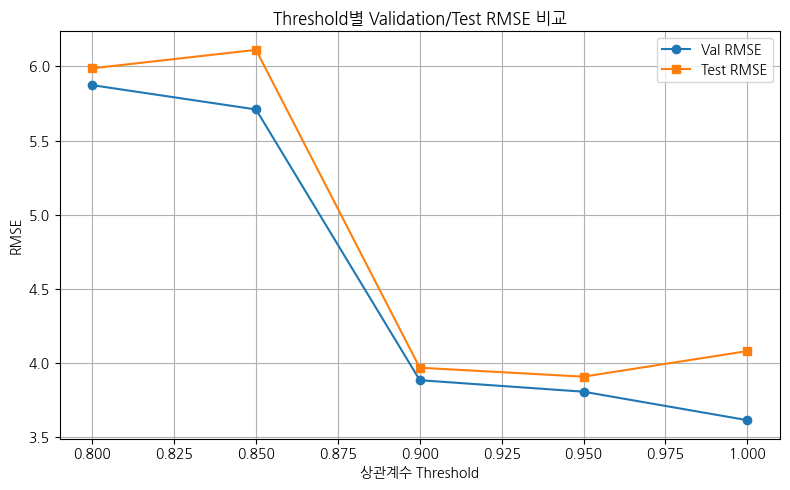

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"▶ 데이터 분할 완료 → Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# ─────────────────────────────────────────────────────────────────
# [2] Threshold 목록 정의 (원하는 후보들을 여기에 적습니다)
# ─────────────────────────────────────────────────────────────────

thresholds = [0.8, 0.85, 0.9, 0.95, 1.0]

# 결과를 저장할 리스트
results = []

for thresh in thresholds:
    # ───────────────────────────────────────────────────────────
    # (2-1) Train+Val 합쳐서 상관행렬 계산 (학습용 피처 간 상관관계)
    #         → 원본 X_train+X_val을 concat 하지 않고,
    #           “X_train”만으로 상관계수를 구해도 되지만
    #           여기서는 Train+Val 전체의 분포를 반영하기 위해 합쳐서 계산합니다.
    # ───────────────────────────────────────────────────────────

    # 2-1-a) Train+Val 합치기
    X_tr_val = pd.concat([X_train, X_val], axis=0)

    # 2-1-b) 상관행렬(절댓값)
    corr_matrix = X_tr_val.corr().abs()

    # 2-1-c) 오른쪽 상삼각(upper triangle)만 남기기
    upper_tri = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )

    # ───────────────────────────────────────────────────────────
    # (2-2) 절댓값 상관계수 > thresh인 피처 쌍 중
    #         “열 이름(컬럼 이름)이 뒤에 오는 변수”를 드랍 후보로 선정
    # ───────────────────────────────────────────────────────────

    to_drop = [
        col
        for col in upper_tri.columns
        if any(upper_tri[col] > thresh)
    ]

    print(f"\n▶ Threshold = {thresh:.2f} 기준으로 삭제할 피처 개수:", len(to_drop))

    # ───────────────────────────────────────────────────────────
    # (2-3) 해당 피처들을 Train/Val/Test 데이터셋에서 모두 삭제
    # ───────────────────────────────────────────────────────────

    X_train_sub = X_train.drop(columns=to_drop)
    X_val_sub   = X_val.drop(columns=to_drop)
    X_test_sub  = X_test.drop(columns=to_drop)

    # ───────────────────────────────────────────────────────────
    # [3] XGBoost 모델 생성 & 학습 → 평가
    # ───────────────────────────────────────────────────────────

    model = xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='rmse'
    )

    model.fit(
        X_train_sub, y_train,
        eval_set=[(X_val_sub, y_val)],
        verbose=False
    )

    # 3-1) Validation 예측 & RMSE
    y_val_pred = model.predict(X_val_sub)
    rmse_val   = np.sqrt(mean_squared_error(y_val, y_val_pred))

    # 3-2) Test 예측 & RMSE, R2
    y_test_pred = model.predict(X_test_sub)
    rmse_test   = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2_test     = r2_score(y_test, y_test_pred)

    print(f"  ▶ After drop({len(to_drop)} features): Val RMSE = {rmse_val:.3f}, Test RMSE = {rmse_test:.3f}, Test R² = {r2_test:.3f}")

    # 결과 저장
    results.append({
        'threshold': thresh,
        'n_dropped': len(to_drop),
        'val_rmse': rmse_val,
        'test_rmse': rmse_test,
        'test_r2': r2_test
    })

# [4] 최종 결과 확인

df_results = pd.DataFrame(results)
print("\n=== Threshold별 모델 성능 비교 ===")
print(df_results)

# 시각화

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(df_results['threshold'], df_results['val_rmse'], marker='o', label='Val RMSE')
plt.plot(df_results['threshold'], df_results['test_rmse'], marker='s', label='Test RMSE')
plt.xlabel("상관계수 Threshold")
plt.ylabel("RMSE")
plt.title("Threshold별 Validation/Test RMSE 비교")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<결과 해석>  
1위: 0.95 (Test RMSE = 3.9080, Test R² = 0.9666)

2위: 0.90 (Test RMSE = 3.9681, Test R² = 0.9656)

3위: 1.00 (Baseline, Test RMSE = 4.0804, Test R² = 0.9636)

4위: 0.80 (Test RMSE = 5.9871, Test R² = 0.9216)

5위: 0.85 (Test RMSE = 6.1115, Test R² = 0.9183)

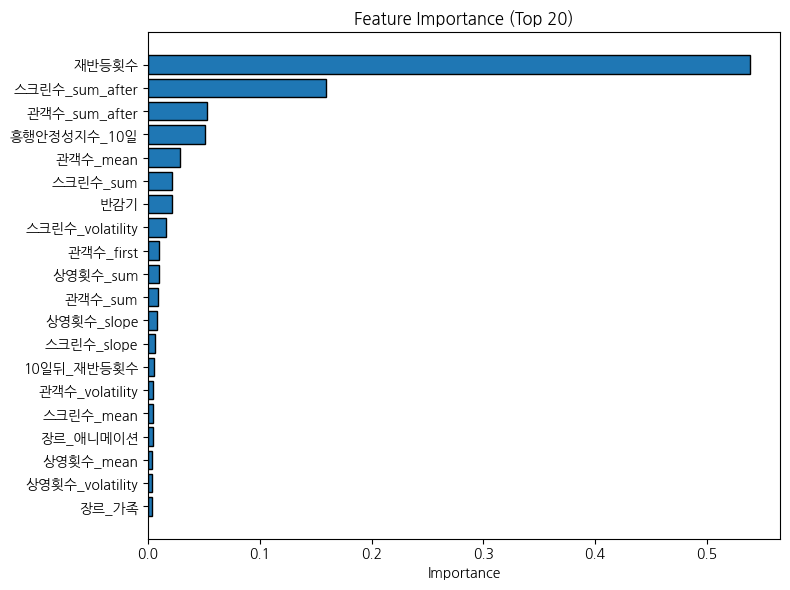

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# (1) 학습된 model의 feature_importances_와 feature_cols가 1:1 대응
importance = model.feature_importances_  # 배열 길이 == len(feature_cols)

# (2) 중요도 내림차순 인덱스 계산
indices = np.argsort(importance)[::-1]

# (3) 상위 N개 피처 선택
top_n = 20
top_indices = indices[:top_n]

# (4) 상위 피처 이름 및 중요도 점수 추출
top_feature_names = [feature_cols[i] for i in top_indices]
top_feature_scores = [importance[i] for i in top_indices]

plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False)

# (6) 가로 막대 그래프로 시각화 (중요도 높은 순서가 위쪽에 오도록 뒤집기)
plt.figure(figsize=(8, 6))
plt.title("Feature Importance (Top 20)")
plt.barh(top_feature_names[::-1], top_feature_scores[::-1], edgecolor='k')
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [ ]:
!pip install lime -q
!pip install shap -q

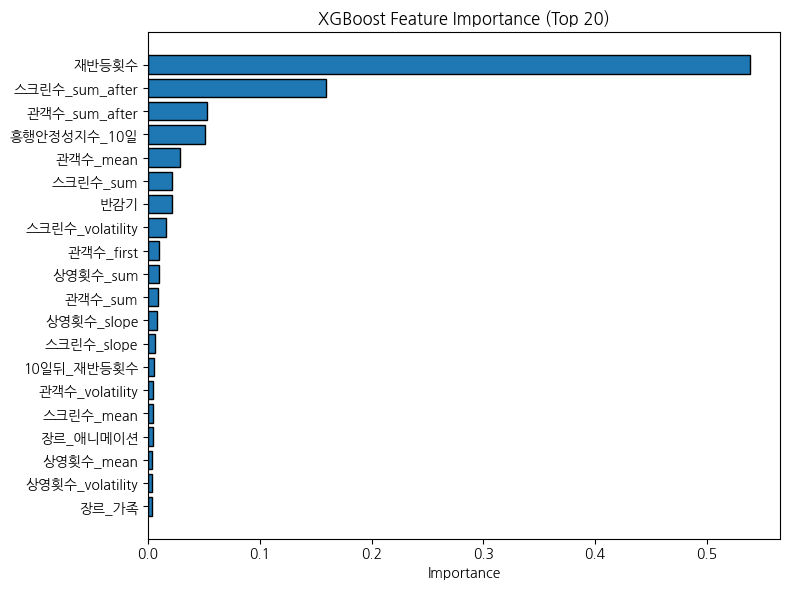

▶ LIME 설명: 실제 상영일수 = 128.0, 예측값 = 135.0


[('스크린수_sum_after > 25.75', 40.86723765236942), ('스크린수_sum > 26.00', 34.51054778688279), ('재반등횟수 > 2.00', 30.981894221301328), ('장르_서부극 <= 0.00', 24.064185251385666), ('관객수_sum_after > 603.75', 22.323497148153454), ('관객수_mean > 102.19', -18.068529104069242), ('장르_서부 <= 0.00', -9.259795243618376), ('관객수_sum > 637.75', 8.717826734506435), ('장르_모험 <= 0.00', -6.860986604518245), ('장르_서사 <= 0.00', 2.177827225273985)]


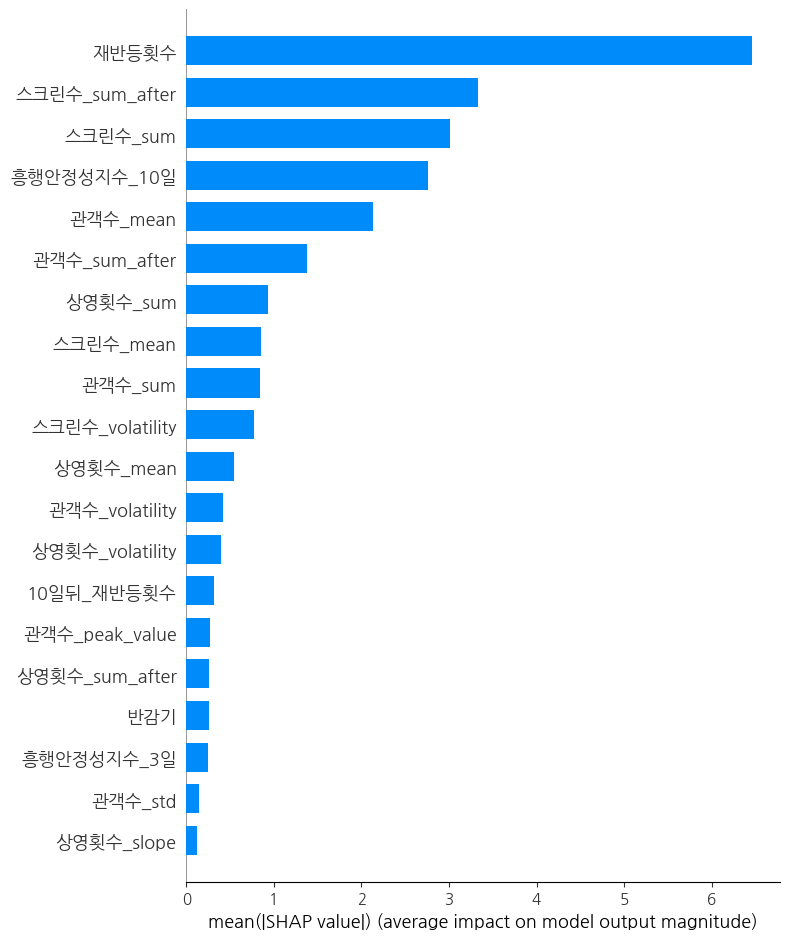

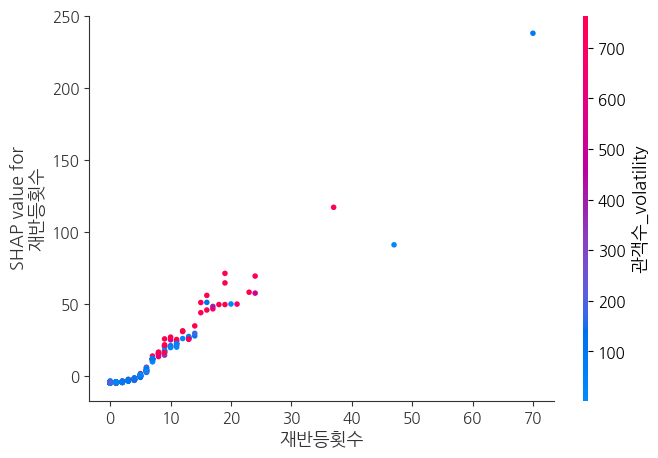

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from lime.lime_tabular import LimeTabularExplainer
import shap

# 1) XGBoost 자체 Feature Importance (기존 코드 재확인)
importance = model.feature_importances_
indices = np.argsort(importance)[::-1]
top_n = 20
top_indices = indices[:top_n]
top_feature_names = [feature_cols[i] for i in top_indices]
top_feature_scores = [importance[i] for i in top_indices]

plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False)

plt.figure(figsize=(8, 6))
plt.title("XGBoost Feature Importance (Top 20)")
plt.barh(top_feature_names[::-1], top_feature_scores[::-1], edgecolor='k')
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


# ─────────────────────────────────────────────────────────────────
# 2) LIME: 한 예측 샘플에 대한 로컬 설명
# ─────────────────────────────────────────────────────────────────

# (2-1) LIME Explainer 생성
#    - training_data: numpy array 형태로 넘겨야 함
#    - feature_names: feature_cols 리스트
#    - class_names: 회귀 문제이므로 ['상영일수']처럼 단일 클래스 이름만 넣어도 무방
explainer = LimeTabularExplainer(
    training_data=X_train_sub.values,
    feature_names=feature_cols,
    mode='regression'
)

# (2-2) Validation 데이터에서 임의의 샘플 하나 선택
i = 5  # 예시: 5번째 샘플
x_valid = X_val_sub.iloc[i].values.reshape(1, -1)
y_true  = y_val.iloc[i]

# (2-3) LIME 설명 생성
lime_exp = explainer.explain_instance(
    data_row=X_val_sub.iloc[i].values,
    predict_fn=model.predict,
    num_features=10  # 상위 10개 피처 설명
)

# (2-4) LIME 결과 출력 (텍스트 형태 및 그래프)
print(f"▶ LIME 설명: 실제 상영일수 = {y_true:.1f}, 예측값 = {model.predict(x_valid)[0]:.1f}")
lime_exp.show_in_notebook(show_table=True)
print(lime_exp.as_list())

# ─────────────────────────────────────────────────────────────────
# 3) SHAP: 전역 및 요약 해석
# ─────────────────────────────────────────────────────────────────

# (3-1) TreeExplainer 생성 (XGBoost 전용)
shap_explainer = shap.TreeExplainer(model)

# (3-2) Validation 셋 전체에 대한 SHAP values 계산
#    - shap_values의 shape: (n_samples, n_features)
shap_values = shap_explainer.shap_values(X_val_sub)

# (3-3) SHAP Summary Plot (global feature importance & 영향 시각화)
#    - Feature 이름(feature_cols)을 그대로 사용
shap.summary_plot(
    shap_values,
    X_val_sub,           # pandas DataFrame (컬럼명이 표시됨)
    feature_names=feature_cols,
    plot_type='bar'      # 막대형 요약: 평균 절댓값 SHAP importance
)

# (3-4) SHAP Dependence Plot (예시: 가장 중요한 피처 중 하나)
#    - top_feature_names[0]이 XGBoost feature_importances_ 기준 1위 피처이므로
shap.dependence_plot(
    top_feature_names[0],  # feature 이름 (예: '관객수_mean' 등)
    shap_values,
    X_val_sub,
    feature_names=feature_cols
)

----------------------------------------

random forest

In [ ]:
from sklearn.model_selection import train_test_split

# Stratified Split이 불가능한 순수 회귀 문제이므로 일반적인 train/val/test 분리 사용
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

# (1) 기본 하이퍼파라미터 설정
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

# (2) 모델 학습
rf.fit(X_train, y_train)

# (3) 검증 세트 예측 및 평가
y_val_pred_rf = rf.predict(X_val)
rmse_rf = root_mean_squared_error(y_val, y_val_pred_rf)
print(f"RandomForest RMSE (Val): {rmse_rf:.3f}")


RandomForest RMSE (Val): 5.948


In [ ]:
from sklearn.impute import SimpleImputer  # Correct import path [1]
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),   # 결측치를 평균(mean)으로 대체
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42))
])

param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth':  [None, 10, 20],
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
print("Best Params:", grid_search.best_params_)
print("Best CV RMSE:", -grid_search.best_score_)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Params: {'rf__max_depth': None, 'rf__n_estimators': 200}
Best CV RMSE: 8.993326093206061


<결과 해석>  
**1. 모델별 성능 비교**  
1-1. Random Forest  
- 검증 세트 RMSE: 5.948
    - 실제 상영일수와 예측 상영일수 간의 차이가 평균 약 6일 정도 발생함.
- 그리드 서치 최적 파라미터
    - max_depth를 제한하지 않고, 트리 개수는 200으로 사용했을 때 성능이 가장 좋았음.
    - rf__n_estimators = 200, rf__max_depth = None
1-2. XGBoost
- 검증 세트 RMSE: 3.612
    - Random Forest 대비 약 절반 정도 오차가 줄었음.
- 테스트 세트 RMSE: 3.340
    - 실제 최종 테스트에서도 RMSE가 3.34로 낮게 나왔습니다
    - 즉, 평균적으로 약 3.3일 정도의 오차만 발생
- 테스트 세트 R_square: 0.976
    - 결정계수가 0.976이라는 것은 입력 피처들이 상영일수 변동의 약 97.6%를 설명하고 예측하고 있다는 의미임.
    - 보통 R_square가 0.9 이상이면 매우 높은 설명력을 가진다고 말하는데, 이 모델의 경우 굿굿임.

**2. Feature Importance**  
1. 재반등 횟수  
- 중요도가 약 0.5로 가장 높음
- 재반등 횟수가 많을수록 상영관에서 장기간 걸쳐 꾸준히 상영될 가능성이 높다는 것을 시사함.
2. 스크린수_sum_after
- 중요도 약 0.13 수준으로, 두 번째로 높습니다.
3. 스크린수_sum
- 중요도 약 0.11
4. 관객수
- 중요도 약 0.04~0.05
5. 흥행안정지수_10일
- 중요도 약 0.03~0.04

**3. SHAP Summary Plot 해석**  
1. y축: feature name (중요도 순으로 위에서 아래)
2. x축: SHAP Value (해당 피처가 상영일 예측에 얼마나 영향을 주었는지를 의미함)
3. 점 색상: 빨간색 -> 높음, 파란색 -> 낮음

**-> 결론: 재반등이 중요함**

In [ ]:
director_feats = ['감독_점수', '감독_영화수_점수', '감독_매출액_점수']

In [ ]:
import itertools

# 3개 피처의 모든 부분집합 리스트 (크기 0 ~ 3)
all_subsets = []
for r in range(len(director_feats)+1):  # r=0,1,2,3
    for comb in itertools.combinations(director_feats, r):
        # tuple → list 로 변환
        all_subsets.append(list(comb))

# 확인
print("감독 관련 부분집합 후보 (총 {}개):".format(len(all_subsets)))
for s in all_subsets:
    print("  ", s)


감독 관련 부분집합 후보 (총 8개):
   []
   ['감독_점수']
   ['감독_영화수_점수']
   ['감독_매출액_점수']
   ['감독_점수', '감독_영화수_점수']
   ['감독_점수', '감독_매출액_점수']
   ['감독_영화수_점수', '감독_매출액_점수']
   ['감독_점수', '감독_영화수_점수', '감독_매출액_점수']


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# 결과를 담을 리스트
results = []

for subset in all_subsets:
    # 1) 이 subset에 해당하는 “감독 관련 피처”만 feature_cols 에 더한 뒤,
    #    나머지 감독 피처는 모두 제외한 최종 피처 리스트를 만듭니다.
    #    즉, 기존 feature_cols에서 감독_feats를 꺼내고, subset에 속한 것만 다시 넣기
    base_feats = [c for c in feature_cols if c not in director_feats]
    selected_feats = base_feats + subset

    # 2) 학습/검증 데이터를 해당 selected_feats 로 재구성
    X_train_sub = X_train[selected_feats]
    X_val_sub   = X_val[selected_feats]

    # 3) XGBoost 모델 새로 생성 (하이퍼파라미터는 앞서 튜닝된 값을 그대로 사용)
    model = xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    # 4) 학습
    model.fit(
        X_train_sub,
        y_train,
        eval_set=[(X_val_sub, y_val)],
        verbose=False
    )
    # 5) 검증 예측 및 RMSE 계산
    y_val_pred = model.predict(X_val_sub)
    mse_val = mean_squared_error(y_val, y_val_pred)
    rmse_val = np.sqrt(mse_val)

    # 6) 결과 저장
    results.append({
        'subset': subset,
        'rmse_val': rmse_val
    })

# (7) 모든 부분집합 결과를 RMSE 오름차순으로 정렬
results_sorted = sorted(results, key=lambda x: x['rmse_val'])

# (8) 상위 5개 (RMSE가 가장 낮은) 조합 출력
print("=== RMSE가 낮은 상위 5개 감독 피처 조합 ===")
for r in results_sorted[:5]:
    print(f"조합: {r['subset']},  Validation RMSE: {r['rmse_val']:.3f}")


=== RMSE가 낮은 상위 5개 감독 피처 조합 ===
조합: ['감독_영화수_점수', '감독_매출액_점수'],  Validation RMSE: 3.459
조합: ['감독_점수', '감독_매출액_점수'],  Validation RMSE: 3.511
조합: ['감독_매출액_점수'],  Validation RMSE: 3.536
조합: ['감독_점수', '감독_영화수_점수'],  Validation RMSE: 3.564
조합: ['감독_영화수_점수'],  Validation RMSE: 3.608


In [ ]:
import itertools
import numpy as np
from sklearn.metrics import mean_squared_error

# 이미 base_feats, director_feats, X_train, X_val, y_train, y_val가 준비되어 있다고 가정

results = []
for r in range(len(director_feats) + 1):       # r = 0,1,2,3
    for comb in itertools.combinations(director_feats, r):
        subset = list(comb)                    # 예: [] 또는 ['감독_점수'] 또는 ['감독_점수','감독_영화수_점수'], ...
        selected_feats = base_feats + subset

        X_train_sub = X_train[selected_feats]
        X_val_sub   = X_val[selected_feats]

        # XGBoost 모델 (앞서 튜닝한 하이퍼파라미터 사용)
        model = xgb.XGBRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        )
        model.fit(X_train_sub, y_train, eval_set=[(X_val_sub, y_val)], verbose=False)

        y_val_pred = model.predict(X_val_sub)
        rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))

        results.append((subset, rmse_val))

# RMSE가 제일 낮은 순서대로 정렬
results.sort(key=lambda x: x[1])
print("=== RMSE가 낮은 순위 ===")
for subset, rmse_val in results:
    print(f"조합: {subset}  →  Validation RMSE: {rmse_val:.3f}")


=== RMSE가 낮은 순위 ===
조합: ['감독_영화수_점수', '감독_매출액_점수']  →  Validation RMSE: 3.459
조합: ['감독_점수', '감독_매출액_점수']  →  Validation RMSE: 3.511
조합: ['감독_매출액_점수']  →  Validation RMSE: 3.536
조합: ['감독_점수', '감독_영화수_점수']  →  Validation RMSE: 3.564
조합: ['감독_영화수_점수']  →  Validation RMSE: 3.608
조합: []  →  Validation RMSE: 3.615
조합: ['감독_점수']  →  Validation RMSE: 3.658
조합: ['감독_점수', '감독_영화수_점수', '감독_매출액_점수']  →  Validation RMSE: 3.747


▶ Validation RMSE: 3.842  
▶ Test RMSE: 3.533  
▶ Test R²  : 0.973

▶ 최종 사용 피처 개수: 45
▶ 최종 사용 피처 목록: ['관객수_mean', '스크린수_mean', '상영횟수_mean', '개봉연도', '개봉월', '개봉요일', '관객수_sum', '스크린수_sum', '상영횟수_sum', '관객수_sum_after', '스크린수_sum_after', '상영횟수_sum_after', '관객수_volatility', '스크린수_volatility', '상영횟수_volatility', '관객수_peak_offset', '스크린수_peak_offset', '상영횟수_peak_offset', '관객수_first', '스크린수_first', '상영횟수_first', '관객수_last', '스크린수_last', '상영횟수_last', '관객수_slope', '스크린수_slope', '상영횟수_slope', '관객수_std', '스크린수_std', '상영횟수_std', '관객수_early_peak', '스크린수_early_peak', '상영횟수_early_peak', '흥행안정성지수_3일', '흥행안정성지수_10일', '반감기', '재반등횟수', '배급사_점수', '배급사_영화수_점수', '배급사_매출액_점수', '배우_점수', '배우_영화수_점수', '배우_매출액_점수', '감독_영화수_점수', '감독_매출액_점수']
▶ 학습 세트: (4278, 45), 검증 세트: (917, 45), 테스트 세트: (917, 45)


<ipython-input-36-ce7229c00499>:132: UserWarning: Glyph 44288 (\N{HANGUL SYLLABLE GWAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-36-ce7229c00499>:132: UserWarning: Glyph 44061 (\N{HANGUL SYLLABLE GAEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-36-ce7229c00499>:132: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-36-ce7229c00499>:132: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-36-ce7229c00499>:132: UserWarning: Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-36-ce7229c00499>:132: UserWarning: Glyph 47536 (\N{HANGUL SYLLABLE RIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-36-ce7229c00499>:132: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout


▶ Validation RMSE: 3.842
▶ Test RMSE: 3.533
▶ Test R²  : 0.973


<ipython-input-36-ce7229c00499>:132: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-36-ce7229c00499>:132: UserWarning: Glyph 46321 (\N{HANGUL SYLLABLE DEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44288 (\N{HANGUL SYLLABLE GWAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44061 (\N{HANGUL SYLLABLE GAEG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLAB

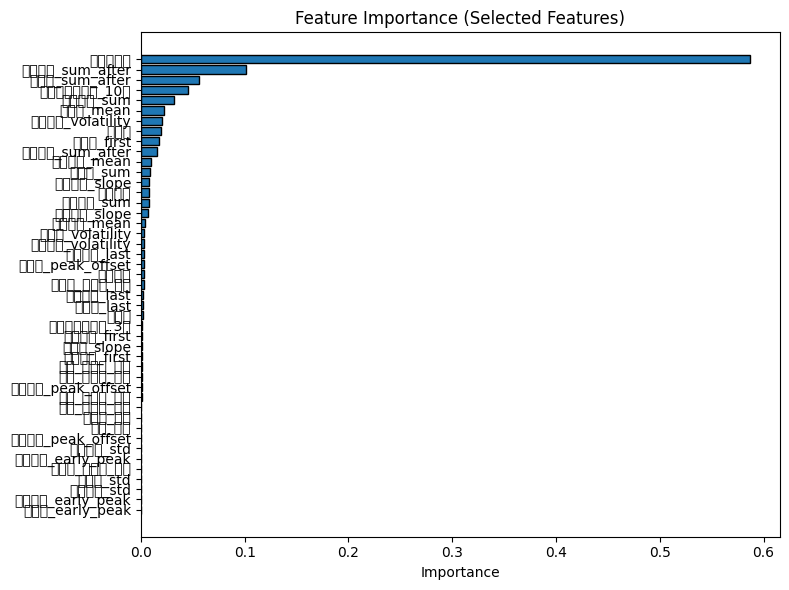

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

feature_cols = [
    '관객수_mean', '스크린수_mean', '상영횟수_mean',
    '개봉연도', '개봉월', '개봉요일',
    '관객수_sum', '스크린수_sum', '상영횟수_sum',
    '관객수_sum_after', '스크린수_sum_after', '상영횟수_sum_after',
    '관객수_volatility', '스크린수_volatility', '상영횟수_volatility',
    '관객수_peak_offset', '스크린수_peak_offset', '상영횟수_peak_offset',
    '관객수_first', '스크린수_first', '상영횟수_first',
    '관객수_last', '스크린수_last', '상영횟수_last',
    '관객수_slope', '스크린수_slope', '상영횟수_slope',
    '관객수_std', '스크린수_std', '상영횟수_std',
    '관객수_early_peak', '스크린수_early_peak', '상영횟수_early_peak',
    '흥행안정성지수_3일', '흥행안정성지수_10일',
    '반감기', '재반등횟수',
    # 감독 관련 3개
    '감독_점수', '감독_영화수_점수', '감독_매출액_점수',
    # 배우/배급사 관련 등 기타 다른 피처들…
    '배급사_점수', '배급사_영화수_점수', '배급사_매출액_점수',
    '배우_점수', '배우_영화수_점수', '배우_매출액_점수'
]

# “감독 관련” 피처 전체
director_feats = ['감독_점수', '감독_영화수_점수', '감독_매출액_점수']

# ───────────────────────────────────────────────────────────
# 2) “감독_영화수_점수”와 “감독_매출액_점수” 두 개만 사용하는 selected_features 구성
# ───────────────────────────────────────────────────────────

# 2-1) 전체 feature_cols 에서 감독 관련 3개를 제거
base_feats = [c for c in feature_cols if c not in director_feats]

# 2-2) 선택된 두 피처만 추가
selected_director = ['감독_영화수_점수', '감독_매출액_점수']
selected_features = base_feats + selected_director

print("▶ 최종 사용 피처 개수:", len(selected_features))
print("▶ 최종 사용 피처 목록:", selected_features)

# ───────────────────────────────────────────────────────────
# 3) 학습 / 검증 / 테스트 데이터 분리
# ───────────────────────────────────────────────────────────

X = df_model[selected_features]
y = df_model['상영일수']

# (1) 학습 데이터와 나머지 데이터 분리 (훈련:70%, 나머지:30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42
)

# (2) 나머지 데이터(30%)를 검증(50%) / 테스트(50%) 로 다시 분할 → 각각 15%씩
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42
)

print(f"▶ 학습 세트: {X_train.shape}, 검증 세트: {X_val.shape}, 테스트 세트: {X_test.shape}")

# ───────────────────────────────────────────────────────────
# 4) XGBoost 모델 생성 및 학습
# ───────────────────────────────────────────────────────────

xgb_reg = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# 학습
xgb_reg.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# ───────────────────────────────────────────────────────────
# 5) 검증 세트 예측 및 RMSE 계산
# ───────────────────────────────────────────────────────────

y_val_pred = xgb_reg.predict(X_val)
mse_val    = mean_squared_error(y_val, y_val_pred)
rmse_val   = np.sqrt(mse_val)
print(f"\n▶ Validation RMSE: {rmse_val:.3f}")

# ───────────────────────────────────────────────────────────
# 6) 테스트 세트 예측 및 최종 평가
# ───────────────────────────────────────────────────────────

y_test_pred = xgb_reg.predict(X_test)
mse_test    = mean_squared_error(y_test, y_test_pred)
rmse_test   = np.sqrt(mse_test)
r2_test     = r2_score(y_test, y_test_pred)

print(f"▶ Test RMSE: {rmse_test:.3f}")
print(f"▶ Test R²  : {r2_test:.3f}")

# ───────────────────────────────────────────────────────────
# 7) 피처 중요도 시각화 (Top 20이 아니라, 모든 selected_features 기준)
# ───────────────────────────────────────────────────────────

importance = xgb_reg.feature_importances_
indices    = np.argsort(importance)[::-1]

plt.figure(figsize=(8, 6))
plt.title("Feature Importance (Selected Features)")
plt.barh(
    [selected_features[i] for i in indices][::-1],
    [importance[i]        for i in indices][::-1],
    edgecolor='k'
)
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

# ───────────────────────────────────────────────────────────────────
# 1) "selected_features" 재확인: 오직 두 개 피처만 사용
# ───────────────────────────────────────────────────────────────────
feature_cols = [
    '관객수_mean', '스크린수_mean', '상영횟수_mean',
    '개봉연도', '개봉월', '개봉요일',
    '관객수_sum', '스크린수_sum', '상영횟수_sum',
    '관객수_sum_after', '스크린수_sum_after', '상영횟수_sum_after',
    '관객수_volatility', '스크린수_volatility', '상영횟수_volatility',
    '관객수_peak_offset', '스크린수_peak_offset', '상영횟수_peak_offset',
    '관객수_first', '스크린수_first', '상영횟수_first',
    '관객수_last', '스크린수_last', '상영횟수_last',
    '관객수_slope', '스크린수_slope', '상영횟수_slope',
    '관객수_std', '스크린수_std', '상영횟수_std',
    '관객수_early_peak', '스크린수_early_peak', '상영횟수_early_peak',
    '흥행안정성지수_3일', '흥행안정성지수_10일',
    '반감기', '재반등횟수',
    # 감독 관련 모두 제거 → 나중에 다시 쓸 두 개만 추가
    '감독_점수', '감독_영화수_점수', '감독_매출액_점수',
    '배급사_점수', '배급사_영화수_점수', '배급사_매출액_점수',
    '배우_점수', '배우_영화수_점수', '배우_매출액_점수'
]
director_feats = ['감독_점수', '감독_영화수_점수', '감독_매출액_점수']

base_feats = [c for c in feature_cols if c not in director_feats]
selected_features = base_feats + ['감독_영화수_점수', '감독_매출액_점수']

# ───────────────────────────────────────────────────────────────────
# 2) 데이터 분할 (학습 70%, 검증 15%, 테스트 15%)
# ───────────────────────────────────────────────────────────────────
X = df_model[selected_features]
y = df_model['상영일수']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# ───────────────────────────────────────────────────────────────────
# 3) GridSearchCV를 이용해 XGBoost 하이퍼파라미터 재튜닝
# ───────────────────────────────────────────────────────────────────

xgb_base = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    use_label_encoder=False,
    eval_metric='rmse'  # 최신 버전에서는 eval_metric이 fit()으로 넘어가면 경고 없슴
)

param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

print("▶ Best Params:", grid_search.best_params_)
print("▶ Best CV RMSE:", -grid_search.best_score_)

# ───────────────────────────────────────────────────────────────────
# 4) 최적 파라미터로 재학습 후 검증/테스트 평가
# ───────────────────────────────────────────────────────────────────
best_xgb = grid_search.best_estimator_

# 4-1) 검증 세트 평가
y_val_pred = best_xgb.predict(X_val)
rmse_val   = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"\n▶ Re-tuned Validation RMSE: {rmse_val:.3f}")

# 4-2) 테스트 세트 평가
y_test_pred = best_xgb.predict(X_test)
rmse_test   = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test     = r2_score(y_test, y_test_pred)
print(f"▶ Re-tuned Test RMSE: {rmse_test:.3f}")
print(f"▶ Re-tuned Test R²  : {r2_test:.3f}")


Fitting 3 folds for each of 243 candidates, totalling 729 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:28:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


▶ Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.6}
▶ Best CV RMSE: 6.517398039499919

▶ Re-tuned Validation RMSE: 3.923
▶ Re-tuned Test RMSE: 3.645
▶ Re-tuned Test R²  : 0.971


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
# 방법 A) 제거하기
#for bad_col in ['관객수_early_peak', '스크린수_early_peak', '상영횟수_early_peak']:
#    if bad_col in df_model.columns:
#        df_model.drop(columns=[bad_col], inplace=True)
#feature_cols = [c for c in feature_cols if c not in ['관객수_early_peak','스크린수_early_peak','상영횟수_early_peak']]

# 방법 B) numeric으로 변환하기 (선택 사항이라면 A 대신 사용)
for col in ['관객수_early_peak', '스크린수_early_peak', '상영횟수_early_peak']:
    df_model[col] = pd.to_numeric(df_model[col], errors='coerce')
    mean_val = df_model[col].mean()
    df_model[col].fillna(mean_val, inplace=True)

# 3) 학습/검증/테스트 분리
X = df_model[feature_cols]
y = df_model['상영일수']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 4) XGBoost Regressor 생성
xgb_reg = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# 5) 학습 (eval_metric 없이)
xgb_reg.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# 6) 검증 세트 예측 및 RMSE 계산
y_val_pred = xgb_reg.predict(X_val)
mse_val    = mean_squared_error(y_val, y_val_pred)
rmse_val   = np.sqrt(mse_val)
print(f"Validation RMSE: {rmse_val:.3f}")

# 7) 테스트 세트 예측 및 최종 평가
y_test_pred = xgb_reg.predict(X_test)
mse_test    = mean_squared_error(y_test, y_test_pred)
rmse_test   = np.sqrt(mse_test)
r2_test     = r2_score(y_test, y_test_pred)

print(f"Test RMSE: {rmse_test:.3f}")
print(f"Test R²  : {r2_test:.3f}")

In [ ]:
# (1) feature_importances_ 배열과 feature_cols 리스트가 1:1 대응합니다.
importance = xgb_reg.feature_importances_  # 길이 = len(feature_cols)

# (2) 중요도 내림차순 인덱스 계산
indices = np.argsort(importance)[::-1]

# (3) 상위 N개 피처 선택
top_n = 20
top_indices = indices[:top_n]

# (4) 상위 피처 이름 및 중요도 점수 추출
top_feature_names = [feature_cols[i] for i in top_indices]
top_feature_scores = [importance[i] for i in top_indices]

# (5) 가로 막대 그래프로 시각화 (중요도 높은 순서가 위쪽에 오도록 뒤집기)
plt.rc('font', family='Nanum Gothic')
plt.figure(figsize=(8, 6))
plt.title("Feature Importance (Top 20)")
plt.barh(top_feature_names[::-1], top_feature_scores[::-1], edgecolor='k')
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [ ]:
import shap

# (1) TreeExplainer 객체 생성
explainer = shap.TreeExplainer(xgb_reg)

# (2) 검증 세트 X_val에 대한 SHAP 값 계산
shap_values = explainer.shap_values(X_val)

# (3) SHAP Summary Plot 그리기
shap.summary_plot(shap_values, X_val)